In [ ]:
import numpy as np
from helper import *
from helper_dep import *
from helper_indep import *
from helper_shapley_sampling import *
from helper_kshap import *
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split
import pandas as pd
from os.path import join
# import warnings
# warnings.filterwarnings('ignore')

# Load and preprocess data
## Load Data
### Original Dataset
- In "sage" package (also from Su-in Lee's group)
- Has categorical variables with multiple levels

In [17]:
dirpath = "/Users/jeremygoldwasser/Desktop/SHAP/Data/bank"
# dirpath = /PATH/TO/DATA
df_orig = pd.read_csv(join(dirpath, "df_orig.csv"))
df_orig # 17 columns, so 16 features

,Age,Job,Marital,Education,Default,Balance,Housing,Loan,Contact,Day,Month,Duration,Campaign,Prev_Days,Prev_Contacts,Prev_Outcome,Success
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,False
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,False
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,False
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,False
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,True
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,True
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,True
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,False


### Binarized Data
- Preprocessed so multilevel categorical features get split into multiple columns - one per binary feature
- Unsurprisingly, the conditioning number of this matrix is near-infinite; we'll need to address this.


In [15]:
X_train_raw = np.load(join(dirpath, "X_train.npy"))
X_test_raw = np.load(join(dirpath, "X_test.npy"))
Y_train = np.load(join(dirpath, "Y_train.npy"))
Y_test = np.load(join(dirpath, "Y_test.npy"))
full_dim = X_train_raw.shape[1] # dimension including all binarized categorical columns
X_df = pd.read_csv(join(dirpath, "X_df.csv"))

xloc_raw = X_test_raw[0].reshape((1,full_dim))

X_df # 48-dimensional

,Age,Default,Balance,Housing,Loan,Day,Duration,Campaign,Prev_Days,Prev_Contacts,...,Month_jun,Month_mar,Month_may,Month_nov,Month_oct,Month_sep,Prev_Outcome_failure,Prev_Outcome_other,Prev_Outcome_success,Prev_Outcome_unknown
0,58,0,2143,1,0,5,261,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
1,44,0,29,1,0,5,151,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
2,33,0,2,1,1,5,76,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
3,47,0,1506,1,0,5,92,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
4,33,0,1,0,0,5,198,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,0,825,0,0,17,977,3,-1,0,...,0,0,0,1,0,0,0,0,0,1
45207,71,0,1729,0,0,17,456,2,-1,0,...,0,0,0,1,0,0,0,0,0,1
45208,72,0,5715,0,0,17,1127,5,184,3,...,0,0,0,1,0,0,0,0,1,0
45209,57,0,668,0,0,17,508,4,-1,0,...,0,0,0,1,0,0,0,0,0,1


## Standardize data

In [50]:
# make mean-zero unit-variance
trainmean, trainstd = np.mean(X_train_raw, axis=0), np.std(X_train_raw, axis=0)
def rescale(x, trainmean, trainstd):
    return (x - trainmean) / trainstd
X_train = rescale(X_train_raw, trainmean, trainstd)
X_test = rescale(X_test_raw, trainmean, trainstd)
xloc = rescale(xloc_raw, trainmean, trainstd)

feature_means = np.mean(X_train, axis=0)
cov_mat = np.cov(X_train, rowvar=False)

## Prepare for dealing with multilevel columns

In [7]:
df_orig.columns = df_orig.columns.str.replace(' ', '_')
categorical_cols = ['Job', 'Marital', 'Education', 'Default', 'Housing',
                    'Loan', 'Contact', 'Month', 'Prev_Outcome']
mapping_dict = get_mapping_dict(df_orig, X_df, X_train_raw, categorical_cols)
mapping_dict

{0: [0],
 1: [1],
 2: [2],
 3: [3],
 4: [4],
 5: [5],
 6: [6],
 7: [7],
 8: [8],
 9: [9],
 10: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
 11: [22, 23, 24],
 12: [25, 26, 27, 28],
 13: [29, 30, 31],
 14: [32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43],
 15: [44, 45, 46, 47]}

# Train neural net

### Define network class & instance

In [21]:
class TwoLayerNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerNet, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.tanh = nn.Tanh()
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.linear1(x)
        out = self.tanh(out)
        out = self.linear2(out)
        out = self.softmax(out)
        return out

class ThreeLayerNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(ThreeLayerNet, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size1)
        self.tanh = nn.Tanh()
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        self.linear3 = nn.Linear(hidden_size2, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.linear1(x)
        out = self.tanh(out)
        out = self.linear2(out)
        out = self.tanh(out)
        out = self.linear3(out)
        out = self.softmax(out)
        return out

### Turn dataset into Pytorch iterable

In [23]:
# Convert the input and label data to PyTorch tensors
inputs = torch.tensor(X_train, dtype=torch.float32)
labels = torch.tensor(Y_train, dtype=torch.long)

# Compute the class weights
class_counts = torch.bincount(labels)
num_samples = len(labels)
class_weights = 1.0 / class_counts.float()
sample_weights = class_weights[labels]

# Create a sampler with balanced weights
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)

# Create a DataLoader with the sampler
dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset, batch_size=32, sampler=sampler)


### Train network. 

In [25]:
torch.manual_seed(0)

# Create an instance
net = TwoLayerNet(input_size=full_dim, hidden_size=50, output_size=2)
# net = ThreeLayerNet(input_size=full_dim, hidden_size1=50, hidden_size2=50, output_size=2)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()#weight=torch.tensor(weights)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)#.01

# Iterate over the training data in batches
num_epochs = 5

# Train the network for the specified number of epochs
for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        # Zero the gradients for this batch
        optimizer.zero_grad()

        # Compute the forward pass of the network
        outputs = net(inputs)

        # Compute the loss for this batch
        loss = criterion(outputs, labels)

        # Compute the gradients of the loss with respect to the parameters
        loss.backward()

        # Update the parameters using the optimizer
        optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/5, Loss: 0.6461
Epoch 2/5, Loss: 0.4329
Epoch 3/5, Loss: 0.3161
Epoch 4/5, Loss: 0.3915
Epoch 5/5, Loss: 0.3143


### Compute training outputs and errors
- Looks good!

In [33]:
test_tensor = torch.tensor(X_test, dtype=torch.float32)

with torch.no_grad():
    outputs = net(test_tensor)

n_test = X_test.shape[0]
n_positive_preds = torch.sum(np.argmax(outputs, axis=1)==1).item()
print("{}/{} predictions are for positive class; really {}"
    .format(n_positive_preds,n_test, np.sum(Y_test==1)))
Y_preds = torch.argmax(outputs, axis=1)
print("Balanced sampling. {}% accuracy".format(round(100*(np.sum(Y_test==Y_preds.numpy())/n_test))))

1130/4521 predictions are for positive class; really 529
Balanced sampling. 84% accuracy


## Compute Gradient and Hessian of neural net w.r.t. input

In [34]:
xloc_torch = torch.tensor(xloc, dtype=torch.float32).requires_grad_(True)
y_pred = net(xloc_torch)[0,1]
y_pred.backward()
gradient = xloc_torch.grad.detach().numpy().reshape((full_dim, 1))


In [35]:
def neural_net(x):
    output = net(x)[0,1] if x.shape[0]==1 else net(x)[:,1]
    return output

def compute_hessian(x):
    if not torch.is_tensor(x):
        x = torch.tensor(x, dtype=torch.float32)
    hessian = torch.autograd.functional.hessian(neural_net, x)
    hessian = hessian.reshape((full_dim,full_dim)).detach().numpy()
    return hessian

hessian = compute_hessian(xloc)
def f_model(x):
    if not torch.is_tensor(x):
        x = torch.tensor(x, dtype=torch.float32)
    return neural_net(x).detach().numpy()

# Assume Feature Independence
## Show true SHAP values of quadratic approximation are sensible

In [45]:
independent_features = True
avg_pred_model, avg_pred_CV = compute_avg_preds(f_model, X_train, xloc, independent_features, gradient, hessian)
print(avg_pred_model, avg_pred_CV) # Uh oh, average pred of linear model is outside of [0,1]

shap_CV_true_indep = compute_true_shap_cv_indep(xloc, gradient, hessian, feature_means, cov_mat, mapping_dict)
sum_shap_CV_true = np.sum(shap_CV_true_indep)
pred = f_model(xloc)

expected_model = pred - avg_pred_model
expected_CV = pred - avg_pred_CV
print("xloc prediction: ", pred)
print("Expected CV:\tf(X)-Ef(X) = ", expected_CV)
print('sum of true CV SHAP vals = ', sum_shap_CV_true) # Pretty close

0.25914243 2.3152832962929017
xloc prediction:  0.07519988
Expected CV:	f(X)-Ef(X) =  -2.240083416586996
sum of true CV SHAP vals =  -2.240146744530648


## Shapley Sampling, assuming independent features
(Theoretical) variance reductions are OK, not terribly impressive

[ 0.32  0.08  0.15  0.28  0.42  0.11  0.27  0.15  0.05  0.62  0.29 -0.09
  0.47  0.08  0.17 -0.09  0.17  0.28 -0.15 -0.16  0.27  0.34  0.11  0.4
  0.39  0.36  0.43  0.39  0.16  0.5   0.32  0.59  0.17  0.63  0.84  0.28
  0.28  0.43  0.44  0.39  0.36  0.37  0.19  0.58  0.08 -0.23  0.18  0.12]


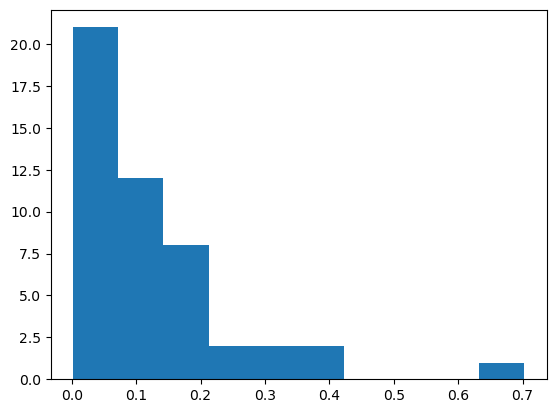

In [46]:
np.random.seed(1)
independent_features = True
obj_ss = cv_shapley_sampling(f_model, X_train, xloc, 
                        independent_features,
                        gradient, hessian,
                        M=100, n_samples_per_perm=10) # M is number of permutations)
final_ests, vshap_ests_model, vshap_ests_CV, corr_ests = obj_ss
print(np.round(corr_ests,2)) # Relatively weak correlations; sometimes negative
plt.hist(corr_ests**2)
plt.show()

## KernelSHAP, assuming independent features
Similar variance reductions; maybe a bit better

[ 0.25  0.52  0.25  0.13  0.32  0.48  0.36  0.23  0.3   0.32  0.3   0.18
  0.38  0.67  0.23  0.45  0.2   0.31 -0.08  0.42  0.09  0.42  0.44  0.63
 -0.01  0.67  0.24  0.66  0.5   0.28  0.55  0.37  0.11  0.01  0.45  0.04
  0.25  0.7   0.39  0.56  0.39  0.01  0.62  0.35  0.55  0.31  0.47  0.49]


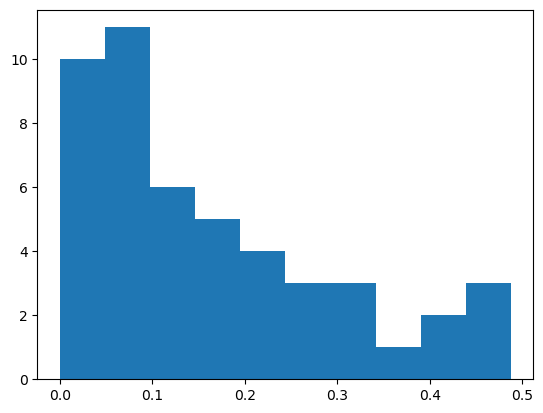

In [49]:
np.random.seed(1)
obj_kshap = cv_kshap(f_model, X_train, xloc, 
            independent_features,
            gradient, hessian,
            M=2000, n_samples_per_perm=10)
final_ests, vshap_ests_model, vshap_ests_CV, corr_ests = obj_kshap
print(np.round(corr_ests,2)) # Pretty weak correlations; sometimes negative
plt.hist(corr_ests**2)
plt.show()

# Dependent Features

## Recondition covariance, then estimate matrices for Control Variate

In [52]:

u, s, vh = np.linalg.svd(cov_mat, full_matrices=True)
K = 10000
s_max = s[0]
min_acceptable = s_max/K
s2 = np.copy(s)
s2[s <= min_acceptable] = min_acceptable
cov2 = np.matmul(u, np.matmul(np.diag(s2), vh))

M_linear = 1000 # 10 seconds/1000 perms or so
D_matrices = make_all_lundberg_matrices(M_linear, cov2)

### Compute almost-true SHAP values of linear model; verify their sum is close to $f(x)-Ef(X)$

In [53]:
avg_CV_empirical = np.mean(f_first_order_approx(f_model,X_train, xloc, gradient))
pred = f_model(xloc)
exp_CV_sum_empirical = pred - avg_CV_empirical

avg_model_empirical = np.mean(f_model(X_train))
exp_model_sum_empirical = pred - avg_model_empirical
shap_CV_true_dep = linear_shap_vals(xloc, D_matrices, feature_means, gradient)
sum_shap_CV_true = np.sum(shap_CV_true_dep)
print(exp_CV_sum_empirical)
print(sum_shap_CV_true)

0.17215737223727684
0.17422887123629013


## Shapley Sampling, assuming dependent features


In [54]:
np.random.seed(1)
independent_features = False
shap_CV_true_dep = linear_shap_vals(xloc, D_matrices, feature_means, gradient)
obj_dep = cv_shapley_sampling(f_model, X_train, xloc,
                    independent_features,
                    gradient, # Don't need to give hessian, since CV is linear model 
                    shap_CV_true=shap_CV_true_dep, # Equivalently, can give D_matrices instead
                    M=100,n_samples_per_perm=10)
final_ests, vshap_ests_model, vshap_ests_CV, corr_ests = obj_dep
print(corr_ests)
print(rank_shap(final_ests))

## KernelSHAP values, assuming dependent features
- Recall default method for variance estimation is bootstrapping w/ 250 resamplings.
    - For the sake of brevity, I won't show alternatives again.

In [ ]:
np.random.seed(1)
obj_kshap_dep = cv_kshap(f_model, X_train, xloc,
                    independent_features,
                    gradient,
                    shap_CV_true=shap_CV_true_dep,
                    M=1000,n_samples_per_perm=10)
final_ests, vshap_ests_model, vshap_ests_CV, corr_ests = obj_kshap_dep
print(corr_ests)
print(rank_shap(final_ests))

[0.93951184 0.94745438 0.94722257 0.94507995 0.92577878 0.94052093
 0.93404105 0.92126558 0.92333779 0.92353307]
[5 3 4 7 6 9 0 2 1 8]
